# OPS: Off-the-grid package made simple 🎻 part II

The tutorials are intended to illustrate the functionalities provided by the off-the-grid package.

It is higly recommended to follow the former introduction and tutorial on spikes.

- 0. Introduction
- 1. Spikes reconstruction from one image
- **2. Spikes reconstruction from covariance of a temporal stack**
- 3. Curves reconstruction from one image
- 4. Dynamic spikes from a temporal stack

# Tutorial II. Off-the-grid Dirac reconstruction from the covariance

## Quick recap

OPS (*Off-the-grid Package made Simple*) revolves around the following objects:
- the set where the source lives $\mathcal X$ is stored in the object `Domain2D`
- Dirac measure are implemented with the object `Spikes2D` (or in case of older implementation with `Mesure2D`)
- in the case of simulated acquisition, one can store all the information in the object `Bruits2D`

Our implementation relies on PyTorch subroutines, hence we implemented a GPU support for the sake of parallelisation. As far as we are concerned, we think that the GPU chiefly makes sense for a great number of Dirac: it is useful mostly for the last step where one plot all the reconstructed spikes on a super-resolved grid. Thus most of our objects incorporate a `dev` parameter. 
We recommand to set `dev='cpu'` if one wants to stay out of trouble.


First, let us import the relevant modules

In [1]:
__saveFig__ = False
__saveVid__ = False
__savePickle__ = False


from skimage import io
import numpy as np
import torch
import pickle
import time

import matplotlib.pyplot as plt

import offgrid

[OPS] Using cpu device


**Remark 🚧:** as in PyTorch, one ought to  be aware of the `dev` settings mayhem. For instance, one should always check if he is plotting the CPU version of the Tensor, otherwise it will presumably raise an error.

In [2]:
# GPU acceleration if needed
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print("[Test] Using {} device".format(device))

[Test] Using cpu device


## Theory

The following is an illustration of the paper [Laville2022 and al.](https://doi.org/10.1109/ICASSP43922.2022.9746845).

Let $\mu : t \mapsto \sum_{i=1}^N a_i(t) \delta_{x_i}$ be the dynamic measure with fluctuating amplitudes. Note that **the positions are fixed**. In this part $y : [0,T] \to \mathrm{L}^2(\mathcal{X})$ is a dynamic acquisition (loosely speaking a stack of images) defined through $y(t) = \Phi \mu (t)$ for $t$ a.e.

Let $\overline{y} = \int_0^T y(\cdot, t) \, \mathrm d t$ be the temporal mean. Let $R_y \in \mathrm{L}^2(\mathcal{X}^2)$ be temporal covariance, defined through $\forall u, v \in \mathcal X$:

$$R_y(u,v) = \int_0^T (y(u,t) - \overline{y}(u)) (y(v,t) - \overline{y}(v)) \, \mathrm d t.$$

Let us denote $\Lambda(m) (u,v) = \int_{\mathcal X} h(x - u) h(x - v) \, \mathrm d m$ the so-called operator of covariance. Then for $m_{M,x} = \sum_{i=1}^N \mathrm{Var}(a_i) \delta_{x_i}$ and $\mathrm{Var}(a_i)$ is the temporal variance of the luminosity $a_i$, one has:

$$R_y = \Lambda m_{M,x}.$$

Hence one can reconstruct through BLASSO w.r.t $R_y$ a measure $m_{M,x}$ sharing the same position as $\mu$.

Let us introduce:

$$ \mathrm{argmin}_{m \in \mathcal{M(X)}} || R_y - \Lambda m ||_\mathcal{H^2}^2 + \lambda ||m||_{\mathrm{TV}} \quad\quad\quad (\mathcal{Q}_\lambda(y))$$

We can compare it to the straightforward BLASSO on the mean $\overline y$:

$$ \mathrm{argmin}_{m \in \mathcal{M(X)}} || \overline y - \Phi m ||_\mathcal{H}^2 + \lambda ||m||_{\mathrm{TV}} \quad\quad\quad (\mathcal{P}_\lambda(\overline y))$$

In the following, we will set `noyau.type = 'double_gaussian'` to specify that our forward operator is now $\Lambda$. 

## Experimental

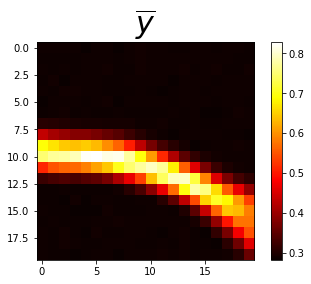

In [3]:
# Load stack
stream = io.imread('datasets/sofi_filaments/tubulin_noiseless_highBg.tif')
pile = torch.from_numpy(np.array(stream, dtype='float64')) [:,15:35,40:60]
pile_max = torch.max(pile)
pile /= pile_max
pile += torch.normal(0, 5e-2, size=pile.shape)

plt.figure()
plt.imshow(pile.mean(0), cmap='hot')
plt.title('$\overline{y}$', fontsize=30)
plt.colorbar()
plt.show()

Compute cumulants, for instance $R_y$ with `covariance_pile`.

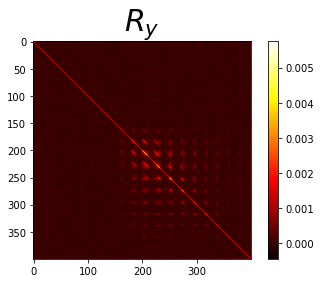

In [4]:
# Compute cumulants
y_bar_cpu = torch.mean(pile.float(), 0)
y_bar = (y_bar_cpu).to(device)
R_y = offgrid.covariance_pile(pile).to(device)


N_ECH = y_bar.shape[0]
X_GAUCHE = 0
X_DROIT = 1

domain = offgrid.Domain2D(X_GAUCHE, X_DROIT, N_ECH, dev=device)
domain_cpu = offgrid.Domain2D(X_GAUCHE, X_DROIT, N_ECH)

FWMH = 2.2875 / N_ECH
SIGMA = FWMH / (2 * np.sqrt(2*np.log(2)))
psf_lambda = offgrid.Kernel2D('double_gaussian', {'sigma_psf': SIGMA})
psf = offgrid.Kernel2D('gaussian', {'sigma_psf': SIGMA})

q = 2**3
super_domain = domain.super_resolve(q)

plt.imshow(R_y.to('cpu'), cmap='hot')
plt.title('$R_y$', fontsize=30)
plt.colorbar()
plt.show()

Solve $(\mathcal{Q}_\lambda(y))$ and $(\mathcal{P}_\lambda(\overline y))$ with Sliding Frank-Wolfe:

In [5]:
lambda_cov = 1e-6
lambda_moy = 1e-3
iteration = 25 # this is just for the desmontration, in general one rather sets 100

(m_cov, nrj_cov, mes_cov) = offgrid.SFW(R_y, domain, psf_lambda, regul=lambda_cov,
                                           nIter=iteration)

(m_moy, nrj_moy, mes_moy) = offgrid.SFW(y_bar - y_bar.min(), domain, psf,
                                           regul=lambda_moy,
                                           nIter=iteration)

print(f'm_cov: {m_cov.N} Diracs')
print(f'm_moy: {m_moy.N} Diracs')

[OPS] Computing SFW on cpu: 100%|██████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.49it/s]

m_cov: 25 Diracs
m_moy: 25 Diracs


Plot the results and save if needed (`__saveFig__ = False` is this tutorial)

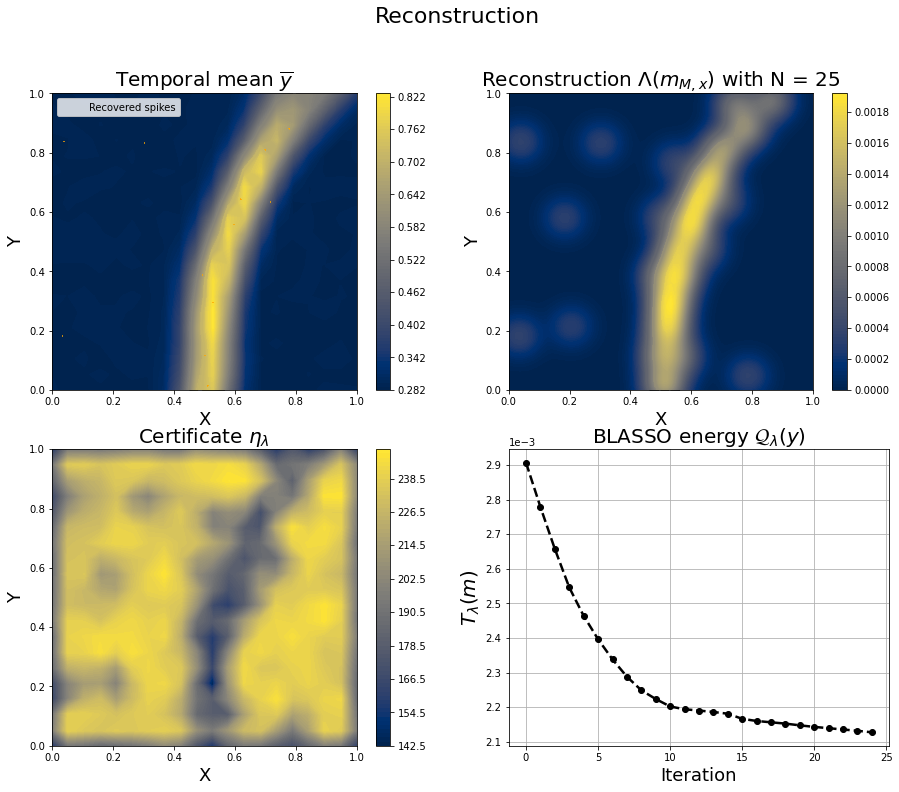

In [9]:
if m_cov.N > 0:
    certificat_V_cov = offgrid.etak(m_cov, R_y, domain, psf_lambda, lambda_cov).to('cpu')
    m_cov_cpu = m_cov.to('cpu')
    offgrid.plot_experimental(m_cov_cpu, domain_cpu, psf_lambda, y_bar_cpu , 
                             nrj_cov[:123],
                             certificat_V_cov,
                             saveFig=__saveFig__, 
                             title='filaments-covar-global')
if m_moy.N > 0:
    certificat_V_moy = offgrid.etak(m_moy, y_bar, domain, psf, lambda_moy).to('cpu')
    m_moy_cpu = m_moy.to('cpu')
    offgrid.plot_experimental(m_moy_cpu, domain_cpu, psf, y_bar_cpu, nrj_moy,
                              certificat_V_moy, 
                              saveFig=__saveFig__, 
                              title='filaments-moy-global')


Thus concluding this part of the tutorial handling the spikes reconstruction from covariance.